# Contents

- [1. Preparation](#1Preparation)
- [2. Define Imports and Variables](#2Define)
- [3. Reading AIS Data (w/o AIS package) ](#3Read)
- [4. Reading AIS Data w/ AIS Package (Recommended)](#4)
- [5. Saving file](#5)
- [6. Spark Stop](#6)

# 1. Preparation <a class="anchor" id="1Preparation"></a>

## 1.1 Kernel
- Choose config template *ais-tt* in Ocean Spark.
- For advanced users, you may request your own config template as the following configuration is added:
    - If thru Ocean Spark config Template, add "spark.sql.parquet.enableVectorizedReader": "false". The configuration should be requested from 
    - If thru Jupyter Notebook, add spark.conf.set("spark.sql.parquet.enableVectorizedReader", "false")
    
    
- After choosing your kernel, wait for the kernel to turn "Idle" (empty circle)



## 1.2 Spark Session
A spark session named ```spark``` is already built for you based on the configuration of your chosen template

In [7]:
spark

The AppName is the same name in the Ocean Spark Dashboard. It is good practice to monitor your notebook in the dashboard. The notebook status should be "Running" (blue circle)

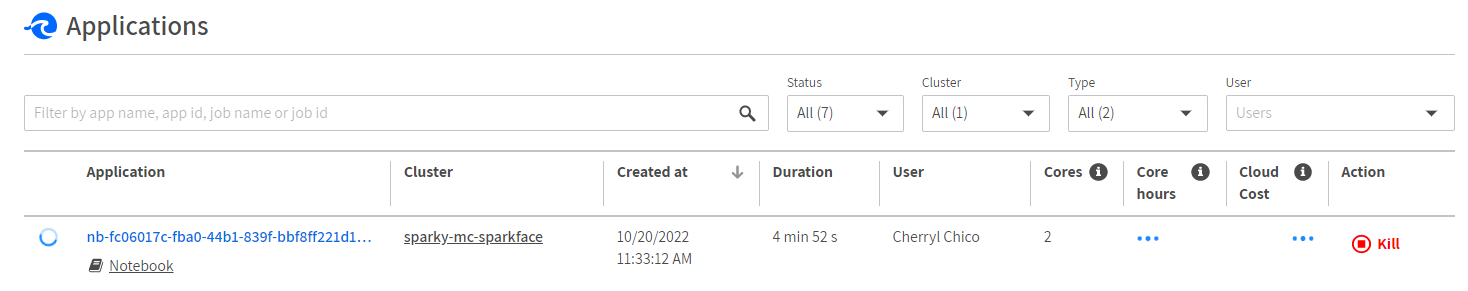

## 1.3 AIS Data Structure

Please see: https://code.officialstatistics.org/trade-task-team-phase-1/samplecode/-/wikis/3.-Overview-of-Architecture

# 2. Define Imports and Variables <a class="anchor" id="2Define"></a>

In [4]:
import pandas as pd
from pyspark.sql import functions as F

#For 3.3.1
#Register Sedona Functions to Spark
from sedona.register import SedonaRegistrator
SedonaRegistrator.registerAll(spark)


#For 3.3.2
from shapely.geometry import Point, Polygon, mapping
import h3.api.numpy_int as h3int 

In [6]:
basepath = "s3a://ungp-ais-data-historical-backup/exact-earth-data/transformed/prod/"

# 3. Reading AIS Data (w/o AIS package) <a class="anchor" id="3Read"></a>

## 3.1 Read ALL AIS for one date 

Read from path ```basepath + "year=<YYYY>/month=<mm>/day=<dd>"```

In [8]:
#Read Data January 1 2022
df = spark.read.parquet(basepath+ "year=2022/month=01/day=01")

In [9]:
#Check-out available fields
df.printSchema()

root
 |-- mmsi: integer (nullable = true)
 |-- imo: integer (nullable = true)
 |-- vessel_name: string (nullable = true)
 |-- callsign: string (nullable = true)
 |-- vessel_type: string (nullable = true)
 |-- vessel_type_code: integer (nullable = true)
 |-- vessel_type_cargo: string (nullable = true)
 |-- vessel_class: string (nullable = true)
 |-- length: double (nullable = true)
 |-- width: double (nullable = true)
 |-- flag_country: string (nullable = true)
 |-- flag_code: integer (nullable = true)
 |-- destination: string (nullable = true)
 |-- eta: integer (nullable = true)
 |-- draught: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- sog: double (nullable = true)
 |-- cog: double (nullable = true)
 |-- rot: double (nullable = true)
 |-- heading: double (nullable = true)
 |-- nav_status: string (nullable = true)
 |-- nav_status_code: integer (nullable = true)
 |-- source: string (nullable = true)
 |-- dt_pos_utc: times

In [21]:
# HHH coba mengurutkan berdasarkan mmsi
df.createOrReplaceTempView("temp_df")
dfH = spark.sql("""
    SELECT mmsi, dt_pos_utc, H3_int_index_8, latitude, longitude
    FROM temp_df
    WHERE mmsi = 201000000
    ORDER BY mmsi
""")
dfH.show(30)

+---------+-------------------+------------------+--------+---------+
|     mmsi|         dt_pos_utc|    H3_int_index_8|latitude|longitude|
+---------+-------------------+------------------+--------+---------+
|201000000|2022-01-01 18:33:53|613956352640811007|   27.77|   48.885|
|201000000|2022-01-01 21:03:58|613956352640811007|   27.77|   48.885|
|201000000|2022-01-01 20:33:57|613956352640811007|   27.77|   48.885|
|201000000|2022-01-01 16:48:53|613956352640811007|   27.77|   48.885|
|201000000|2022-01-01 02:21:20|613956352640811007|   27.77|   48.885|
|201000000|2022-01-01 23:45:52|613956352640811007|   27.77|   48.885|
|201000000|2022-01-01 21:15:54|613956352640811007|   27.77|   48.885|
|201000000|2022-01-01 00:00:31|613956352640811007|   27.77|   48.885|
|201000000|2022-01-01 00:42:19|613956352640811007|   27.77|   48.885|
|201000000|2022-01-01 23:54:57|613956352640811007|   27.77|   48.885|
|201000000|2022-01-01 22:52:01|613956352640811007|   27.77|   48.885|
|201000000|2022-01-0

In [16]:
# HHH
# melihat setiap mmsi muncul berapa kali
# Menambahkan DataFrame hasil penghitungan ke dalam sebuah DataFrame baru
result_df = spark.sql("""
    SELECT mmsi, COUNT(*) AS jumlah_muncul
    FROM temp_df
    GROUP BY mmsi
    ORDER BY mmsi
""")

# Menampilkan hasil
result_df.show(30)

+---------+-------------+
|     mmsi|jumlah_muncul|
+---------+-------------+
|201000000|           43|
|201000140|           78|
|201006210|          144|
|201008120|           62|
|201011000|           17|
|201012503|           85|
|201042519|            5|
|201100094|          149|
|201100115|            3|
|201100124|          244|
|201100134|           38|
|201100147|           70|
|201100149|           55|
|201100151|          108|
|201100152|          122|
|201100179|          169|
|201100180|            1|
|201100182|            1|
|201100183|          150|
|201100187|           84|
|201100532|            1|
|201103041|           50|
|201107602|            1|
|201121851|            1|
|201128006|            1|
|201204005|            4|
|201204131|          133|
|201205281|           18|
|201208170|           81|
|201211180|          220|
+---------+-------------+
only showing top 30 rows



In [6]:
#Count all rows
df.count()

22136014

In [7]:
# Show sample 1 data
# df.show(n=1, vertical=True)
df.show(n=5, vertical=True)

-RECORD 0---------------------------------
 mmsi              | 205654000            
 imo               | 9691279              
 vessel_name       | DN97                 
 callsign          | ORRK                 
 vessel_type       | Port Tender          
 vessel_type_code  | 53                   
 vessel_type_cargo | null                 
 vessel_class      | A                    
 length            | 17.0                 
 width             | 6.0                  
 flag_country      | Belgium              
 flag_code         | 205                  
 destination       | ZEEBRUGGE            
 eta               | 10081400             
 draught           | 1.2                  
 longitude         | 3.20316              
 latitude          | 51.32248833          
 sog               | 0.0                  
 cog               | 0.0                  
 rot               | 0.0                  
 heading           | 0.0                  
 nav_status        | Not Defined          
 nav_status

## 3.2 To read ALL AIS for multiple dates

In [17]:
#Read for one-week
#puth all date paths in a list
df = spark.read.parquet(*[basepath + "year=2022/month=01/day=01",
                          basepath + "year=2022/month=01/day=02",
                          basepath + "year=2022/month=01/day=03",
                          basepath + "year=2022/month=01/day=04",
                          basepath + "year=2022/month=01/day=05",
                          basepath + "year=2022/month=01/day=06",
                          basepath + "year=2022/month=01/day=07"]
                       )

In [18]:
#Count all rows
df.count()

160650992

Row(mmsi=205654000, imo=9691279, vessel_name='DN97', callsign='ORRK', vessel_type='Port Tender', vessel_type_code=53, vessel_type_cargo=None, vessel_class='A', length=17.0, width=6.0, flag_country='Belgium', flag_code=205, destination='ZEEBRUGGE', eta=10081400, draught=1.2, longitude=3.20316, latitude=51.32248833, sog=0.0, cog=0.0, rot=0.0, heading=0.0, nav_status='Not Defined', nav_status_code=15, source='T-AIS', dt_pos_utc=datetime.datetime(2022, 1, 1, 21, 17, 43), dt_static_utc=datetime.datetime(2022, 1, 1, 21, 14, 24), dt_insert_utc=datetime.datetime(2022, 1, 1, 21, 17, 48), vessel_type_main=None, vessel_type_sub=None, message_type=1, eeid=4897682788452534256, source_filename='s3a://ungp-ais-data-historical-backup/exact-earth-data/nonprod/year=2022/month=01/day=01/20220101211833.csv.gz', H3index_0='8019fffffffffff', H3_int_index_0=576918149140578303, H3_int_index_1=581412952674926591, H3_int_index_2=585913253767413759, H3_int_index_3=590416715955830783, H3_int_index_4=5949203069932

In [16]:
#Create a date column and then count rows per date
df = df.withColumn('date', F.to_date("dt_insert_utc"))
df.groupBy('date').count().show()

+----------+--------+
|      date|   count|
+----------+--------+
|2022-01-06|23319382|
|2022-01-03|22998973|
|2022-01-07|23136598|
|2022-01-04|23132660|
|2022-01-05|23113870|
|2022-01-01|22136014|
|2022-01-02|22813495|
+----------+--------+



In [10]:
#if they have the same path prefix, add an asterisk at the end of the prefix
#Read Data for January 20-29, 2022
df = spark.read.parquet(basepath+ "year=2022/month=01/day=2*")

In [11]:
#Create a date column and then count rows per date
df = df.withColumn('date', F.to_date("dt_insert_utc"))
df.groupBy('date').count().show()

+----------+--------+
|      date|   count|
+----------+--------+
|2022-01-29|22345813|
|2022-01-24|22304315|
|2022-01-23|22762479|
|2022-01-25|22373746|
|2022-01-22|21769237|
|2022-01-28|22588496|
|2022-01-20|23205500|
|2022-01-21|22566850|
|2022-01-26|22304177|
|2022-01-27|22364684|
+----------+--------+



## 3.3 Filtering using geo-location

Read AIS data for January 1, 2022 and get only AIS for mmsi 20564000 where location is within 5 units from point (3.20316 51.32248833)

### 3.3.1 Using Geometry objects via Sedona

Read AIS data for January 1, 2022 and get only AIS for mmsi 20564000 where location is within 5 units from point (3.20316 51.32248833)

In [21]:
#Read Data January 1 2022
df = spark.read.parquet(basepath+ "year=2022/month=01/day=01")

#Cast the Latitude and Longitude as Point Geometry Objects
df.createOrReplaceTempView("temp_df")
df2 = spark.sql("""
                select dt_pos_utc, mmsi, longitude, latitude, H3_int_index_7, ST_Point(cast(longitude as Decimal(24,20)), cast(latitude as Decimal(24,20))) as pos 
                from temp_df
                """)

df2.show(truncate=False)

+-------------------+---------+------------+-----------+------------------+--------------------------------+
|dt_pos_utc         |mmsi     |longitude   |latitude   |H3_int_index_7    |pos                             |
+-------------------+---------+------------+-----------+------------------+--------------------------------+
|2022-01-01 21:17:43|205654000|3.20316     |51.32248833|608431098929610751|POINT (3.20316 51.32248833)     |
|2022-01-01 23:39:13|533170107|128.092125  |29.39535   |609306276479893503|POINT (128.092125 29.39535)     |
|2022-01-01 11:20:11|205654000|3.20309167  |51.32246333|608431098929610751|POINT (3.20309167 51.32246333)  |
|2022-01-01 23:30:55|533170107|128.116055  |29.41073667|609306278258278399|POINT (128.116055 29.41073667)  |
|2022-01-01 14:32:32|205654000|3.20318     |51.32247833|608431098929610751|POINT (3.20318 51.32247833)     |
|2022-01-01 13:57:12|373445000|128.72      |29.50333333|609306284348407807|POINT (128.72 29.50333333)      |
|2022-01-01 15:12:5

In [22]:
# coba ambil vessel type aja
df3 =  spark.sql("""
                select vessel_type
                from temp_df
                """)
df3.show(truncate=False)

+-----------+
|vessel_type|
+-----------+
|Port Tender|
|Cargo      |
|Port Tender|
|Cargo      |
|Port Tender|
|Cargo      |
|Port Tender|
|Tanker     |
|Port Tender|
|Cargo      |
|Port Tender|
|Cargo      |
|Port Tender|
|Cargo      |
|Port Tender|
|Tanker     |
|Port Tender|
|Cargo      |
|Port Tender|
|Cargo      |
+-----------+
only showing top 20 rows



In [2]:
# coba ambil vessel type aja
# df4 =  spark.sql("""
#                 select *
#                 from temp_df
#                 order by mmsi
#                 """)
# df4.show(truncate=False)


NameError: name 'temp_df' is not defined

In [26]:
# coba count
from pyspark.sql import functions as F

# Mengelompokkan berdasarkan vessel_type dan menghitung jumlah setiap jenis kapal, kemudian mengurutkan dari yang terbanyak
result = df3.groupBy("vessel_type").count().orderBy(F.desc("count"))

# Menampilkan hasil perhitungan yang telah diurutkan
result.show()

+---------------+-------+
|    vessel_type|  count|
+---------------+-------+
|          Cargo|8415885|
|         Tanker|2531881|
|        Fishing|2346629|
|            Tug|1740898|
|          Other|1319422|
|      Passenger|1198229|
| Pleasure Craft|1092665|
|        Unknown| 786197|
|         Towing| 516117|
|        Sailing| 494985|
|          Spare| 328313|
|       Dredging| 280561|
|          Pilot| 201361|
|            HSC| 158205|
|            SAR| 131710|
|    Port Tender|  97730|
|       Reserved|  92192|
|Law Enforcement|  89124|
|            WIG|  81771|
|  Not Available|  64631|
+---------------+-------+
only showing top 20 rows



In [14]:
#pos is Geometry object. We can only use this type in spark if we are using Sedona
df2.printSchema()

root
 |-- dt_pos_utc: timestamp (nullable = true)
 |-- mmsi: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- H3_int_index_7: long (nullable = true)
 |-- pos: geometry (nullable = false)



In [15]:
#Create a buffer which is 5 units from pos
#select only rows where pos is within buffer and mmsi is defined mmsi
df2.createOrReplaceTempView("temp_df")
df3 = spark.sql("""
                select  *, ST_Buffer(ST_Point(3.20316, 51.32248833), 5) as buffer 
                from temp_df 
                where mmsi = 205654000 and ST_Contains(ST_Buffer(ST_Point(3.20316, 51.32248833), 5), pos)
                """)
df3.show()

+-------------------+---------+----------+-----------+------------------+--------------------+--------------------+
|         dt_pos_utc|     mmsi| longitude|   latitude|    H3_int_index_7|                 pos|              buffer|
+-------------------+---------+----------+-----------+------------------+--------------------+--------------------+
|2022-01-01 21:17:43|205654000|   3.20316|51.32248833|608431098929610751|POINT (3.20316 51...|POLYGON ((8.20316...|
|2022-01-01 11:20:11|205654000|3.20309167|51.32246333|608431098929610751|POINT (3.20309167...|POLYGON ((8.20316...|
|2022-01-01 14:32:32|205654000|   3.20318|51.32247833|608431098929610751|POINT (3.20318 51...|POLYGON ((8.20316...|
|2022-01-01 15:12:51|205654000|3.20313667|51.32249333|608431098929610751|POINT (3.20313667...|POLYGON ((8.20316...|
|2022-01-01 01:13:03|205654000|3.20311333|51.32249167|608431098929610751|POINT (3.20311333...|POLYGON ((8.20316...|
|2022-01-01 23:49:03|205654000|   3.20316|51.32243333|608431098929610751

In [16]:
#pos and buffer is Geometry object. We can only use this type in spark if we are using Sedona
df3.printSchema()

root
 |-- dt_pos_utc: timestamp (nullable = true)
 |-- mmsi: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- H3_int_index_7: long (nullable = true)
 |-- pos: geometry (nullable = false)
 |-- buffer: geometry (nullable = false)



### 3.3.2 Using H3 Indices 

Create the buffer polygon in shapely and then fill the polygon with h3 indices

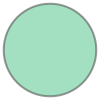

In [17]:
#Create point buffer
buffer = Point(3.20316, 51.32248833).buffer(5)
buffer

In [18]:
#fill the buffer with h3 indices resolution 7
h3_list = h3int.polyfill(mapping(buffer), 7, geo_json_conformant=True)
len(h3_list)

134664

In [19]:
#convert the h3 indices into type double
h3_list_int = [x.astype('double') for x in h3_list]

In [20]:
type(h3_list_int[0])

numpy.float64

In [21]:
h3_list_int[0]

6.084304967785513e+17

In [22]:
#Read Data January 1 2022
df = spark.read.parquet(basepath+ "year=2022/month=01/day=01")

df3 = df.select('dt_pos_utc', 'mmsi', 'longitude', 'latitude','H3_int_index_7') \
        .filter((F.col('mmsi') == 205654000) & F.col('H3_int_index_7').isin(h3_list_int))

In [23]:
df3.show()

+-------------------+---------+----------+-----------+------------------+
|         dt_pos_utc|     mmsi| longitude|   latitude|    H3_int_index_7|
+-------------------+---------+----------+-----------+------------------+
|2022-01-01 21:17:43|205654000|   3.20316|51.32248833|608431098929610751|
|2022-01-01 11:20:11|205654000|3.20309167|51.32246333|608431098929610751|
|2022-01-01 14:32:32|205654000|   3.20318|51.32247833|608431098929610751|
|2022-01-01 15:12:51|205654000|3.20313667|51.32249333|608431098929610751|
|2022-01-01 01:13:03|205654000|3.20311333|51.32249167|608431098929610751|
|2022-01-01 23:49:03|205654000|   3.20316|51.32243333|608431098929610751|
|2022-01-01 04:55:32|205654000|3.20312833|  51.322465|608431098929610751|
|2022-01-01 16:34:01|205654000|  3.203095|51.32243833|608431098929610751|
|2022-01-01 16:23:52|205654000|3.20311333|51.32241833|608431098929610751|
|2022-01-01 22:58:34|205654000|3.20311333|51.32245667|608431098929610751|
|2022-01-01 18:05:01|205654000|3.20309

In [24]:
df3.printSchema()

root
 |-- dt_pos_utc: timestamp (nullable = true)
 |-- mmsi: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- H3_int_index_7: long (nullable = true)



# 4. Reading AIS Data w/ AIS Package (Recommended) <a class="anchor" id="4"></a>

The AIS package consists of helper functions to read and filter AIS data based on select fields. It ensures efficient processing by:
1. Generating paths for reading based on dates to utilize partitioning
2. Filters polygons according to h3 indices first, and then via sedona geometries to fit exactly the polygon
3. Uses broadcast-join for filtering 

The package also contains other helper functions for manipulating h3 indices, polygons, reading small files from github, and saving small files locally.

The repository is saved in: https://code.officialstatistics.org/trade-task-team-phase-1/ais. This includes the sample notebooks on how to use the functions. 

# 5. Saving file <a class="anchor" id="5"></a>

You can write in s3 using the cluster by saving output of your spark codes using prefix: “s3a://ungp-ais-data-historical-backup/user_temp/” . Please use a unique path for your files (e.g. “s3a://ungp-ais-data-historical-backup/user_temp/adb_cherryl”). Storage is temporary, and files will be visible to all users.

In [25]:
#Read Data January 1 2022
df = spark.read.parquet(basepath+ "year=2022/month=01/day=01")

#Cast the Latitude and Longitude as Point Geometry Objects
df.createOrReplaceTempView("temp_df")
df2 = spark.sql("""
                select dt_pos_utc, mmsi, longitude, latitude, H3_int_index_7, ST_Point(cast(longitude as Decimal(24,20)), cast(latitude as Decimal(24,20))) as pos 
                from temp_df
                """)

#Create a buffer which is 5 units from pos
#select only rows where pos is within buffer and mmsi is defined mmsi
df2.createOrReplaceTempView("temp_df")
df3 = spark.sql("""
                select  *, ST_Buffer(ST_Point(3.20316, 51.32248833), 5) as buffer 
                from temp_df 
                where mmsi = 205654000 and ST_Contains(ST_Buffer(ST_Point(3.20316, 51.32248833), 5), pos)
                """)

In [26]:
df3.count()

237

In [27]:
df3.printSchema()

root
 |-- dt_pos_utc: timestamp (nullable = true)
 |-- mmsi: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- H3_int_index_7: long (nullable = true)
 |-- pos: geometry (nullable = false)
 |-- buffer: geometry (nullable = false)



In [29]:
save_path = "s3a://ungp-ais-data-historical-backup/user_temp/"
save_path_unique = save_path + "test/"

In [30]:
#save as csv
# remove geometry objects before saving as csv
df3.drop("pos","buffer").write.option("header",True).mode("overwrite").csv(save_path_unique + "test.csv")

In [31]:
#read saved csv
test = spark.read.csv(save_path_unique + "test.csv", header=True)
test.show()

+--------------------+---------+----------+-----------+------------------+
|          dt_pos_utc|     mmsi| longitude|   latitude|    H3_int_index_7|
+--------------------+---------+----------+-----------+------------------+
|2022-01-01T08:28:...|205654000|3.20313667|  51.322465|608431098929610751|
|2022-01-01T08:48:...|205654000|  3.203105|51.32250167|608431098929610751|
|2022-01-01T12:51:...|205654000|3.20315333|   51.32251|608431098929610751|
|2022-01-01T11:50:...|205654000|3.20302833|51.32247167|608431098929610751|
|2022-01-01T20:37:...|205654000|   3.20313|51.32243167|608431098929610751|
|2022-01-01T08:58:...|205654000|3.20311667|51.32246833|608431098929610751|
|2022-01-01T10:39:...|205654000|    3.2031|51.32245833|608431098929610751|
|2022-01-01T06:26:...|205654000|3.20310333|51.32245833|608431098929610751|
|2022-01-01T15:02:...|205654000|  3.203155|51.32250667|608431098929610751|
|2022-01-01T00:22:...|205654000|3.20312167|51.32246667|608431098929610751|
|2022-01-01T16:44:...|205

In [32]:
#save as spark file
# remove geometry objects
df3.drop("pos","buffer").write.mode("overwrite").parquet(save_path_unique + "test")

In [33]:
#read saved parquet
test = spark.read.parquet(save_path_unique + "test")
test.show()

+-------------------+---------+----------+-----------+------------------+
|         dt_pos_utc|     mmsi| longitude|   latitude|    H3_int_index_7|
+-------------------+---------+----------+-----------+------------------+
|2022-01-01 08:28:02|205654000|3.20313667|  51.322465|608431098929610751|
|2022-01-01 08:48:21|205654000|  3.203105|51.32250167|608431098929610751|
|2022-01-01 12:51:21|205654000|3.20315333|   51.32251|608431098929610751|
|2022-01-01 11:50:41|205654000|3.20302833|51.32247167|608431098929610751|
|2022-01-01 20:37:11|205654000|   3.20313|51.32243167|608431098929610751|
|2022-01-01 08:58:32|205654000|3.20311667|51.32246833|608431098929610751|
|2022-01-01 10:39:41|205654000|    3.2031|51.32245833|608431098929610751|
|2022-01-01 06:26:42|205654000|3.20310333|51.32245833|608431098929610751|
|2022-01-01 15:02:51|205654000|  3.203155|51.32250667|608431098929610751|
|2022-01-01 00:22:31|205654000|3.20312167|51.32246667|608431098929610751|
|2022-01-01 16:44:01|205654000|3.20308

# 6. Spark Stop <a class="anchor" id="6"></a>

Always end your spark session after you finished with all the spark tasks

In [ ]:
spark.stop()

In [ ]:
import os

current_dir = os.getcwd()
print(current_dir)